In [1]:
%matplotlib inline


# WV Satellite Overlay Example


Plot a Gini Satellite file and overlay GFS-based data.

Using the Gini read capability of MetPy with Siphon to bring in the best GFS
data according to the current time, plot an overlay of WV imagery with 300-hPa
Geopotential Heights and Wind Barbs.


Begin with imports, need a lot for this task.



In [18]:
from datetime import datetime
import json
import urllib.request

import cartopy.crs as ccrs
import cartopy.feature as cfeature
from matplotlib import patheffects
import matplotlib.pyplot as plt
import metpy  # noqa: F401
import metpy.calc as mpcalc
from metpy.plots.ctables import registry
from metpy.units import units
import numpy as np
from siphon.catalog import TDSCatalog
import xarray as xr
from xarray.backends import NetCDF4DataStore

Get satellite data and set projection based on that data.



In [221]:
# Scan the catalog and download the data
satcat = TDSCatalog('https://thredds.ucar.edu/thredds/catalog/satellite/goes/east/products/CloudTopTemperature/FullDisk/current/catalog.xml')

ds = satcat.datasets[-1]

print(ds)
print(ds.access_urls)

OR_ABI-L2-ACHTF-M6_G16_s20193600610222_e20193600619530_c20193600621598.nc
{'OPENDAP': 'https://thredds.ucar.edu/thredds/dodsC/satellite/goes/east/products/CloudTopTemperature/FullDisk/current/OR_ABI-L2-ACHTF-M6_G16_s20193600610222_e20193600619530_c20193600621598.nc', 'WCS': 'https://thredds.ucar.edu/thredds/wcs/satellite/goes/east/products/CloudTopTemperature/FullDisk/current/OR_ABI-L2-ACHTF-M6_G16_s20193600610222_e20193600619530_c20193600621598.nc', 'WMS': 'https://thredds.ucar.edu/thredds/wms/satellite/goes/east/products/CloudTopTemperature/FullDisk/current/OR_ABI-L2-ACHTF-M6_G16_s20193600610222_e20193600619530_c20193600621598.nc', 'NetcdfSubset': 'https://thredds.ucar.edu/thredds/ncss/satellite/goes/east/products/CloudTopTemperature/FullDisk/current/OR_ABI-L2-ACHTF-M6_G16_s20193600610222_e20193600619530_c20193600621598.nc', 'HTTPServer': 'https://thredds.ucar.edu/thredds/fileServer/satellite/goes/east/products/CloudTopTemperature/FullDisk/current/OR_ABI-L2-ACHTF-M6_G16_s201936006102

In [222]:
ds = ds.remote_access(use_xarray=True)

/home/steidani/miniconda3/envs/weather_2019/lib/python3.7/site-packages/xarray/conventions.py:494: SerializationWarning: variable 'TEMP' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  use_cftime=use_cftime,


In [223]:
ds

<xarray.Dataset>
Dimensions:                                 (number_of_LZA_bounds: 2, number_of_SZA_bounds: 2, number_of_image_bounds: 2, number_of_time_bounds: 2, x: 5424, y: 5424)
Coordinates:
    t                                       datetime64[ns] ...
  * y                                       (y) float32 0.151844 ... -0.151844
  * x                                       (x) float32 -0.151844 ... 0.151844
    y_image                                 float32 ...
    x_image                                 float32 ...
    local_zenith_angle                      float32 ...
    solar_zenith_angle                      float32 ...
Dimensions without coordinates: number_of_LZA_bounds, number_of_SZA_bounds, number_of_image_bounds, number_of_time_bounds
Data variables:
    TEMP                                    (y, x) float32 ...
    DQF                                     (y, x) float32 ...
    time_bounds                             (number_of_time_bounds) datetime64[ns] ...
    goes_imager_projection                  int32 ...
    y_image_bounds                          (number_of_image_bounds) float32 ...
    x_image_bounds                          (number_of_image_bounds) float32 ...
    nominal_satellite_subpoint_lat          float32 ...
    nominal_satellite_subpoint_lon          float32 ...
    nominal_satellite_height                float32 ...
    geospatial_lat_lon_extent               float32 ...
    outlier_pixels                          float64 ...
    minimum_cloud_top_temperature           float32 ...
    maximum_cloud_top_temperature           float32 ...
    mean_cloud_top_temperature              float32 ...
    std_dev_cloud_top_temperature           float32 ...
    algorithm_dynamic_input_data_container  int32 ...
    processing_parm_version_container       int32 ...
    algorithm_product_version_container     int32 ...
    local_zenith_angle_bounds               (number_of_LZA_bounds) float32 ...
    solar_zenith_angle_bounds               (number_of_SZA_bounds) float32 ...
    percent_uncorrectable_GRB_errors        float32 ...
    percent_uncorrectable_L0_errors         float32 ...
    cloud_pixels                            float64 ...
Attributes:
    naming_authority:          gov.nesdis.noaa
    Conventions:               CF-1.7
    Metadata_Conventions:      Unidata Dataset Discovery v1.0
    standard_name_vocabulary:  CF Standard Name Table (v35, 20 July 2016)
    institution:               DOC/NOAA/NESDIS > U.S. Department of Commerce,...
    project:                   GOES
    production_site:           NSOF
    production_environment:    OE
    spatial_resolution:        2km at nadir
    orbital_slot:              GOES-East
    platform_ID:               G16
    instrument_type:           GOES R Series Advanced Baseline Imager
    scene_id:                  Full Disk
    instrument_ID:             FM1
    dataset_name:              OR_ABI-L2-ACHTF-M6_G16_s20193600610222_e201936...
    iso_series_metadata_id:    8c98eff0-afda-11e1-afa6-0800200c9a66
    title:                     ABI L2 Cloud Top Temperature
    summary:                   The Cloud Top Temperature product consists of ...
    keywords:                  ATMOSPHERE > CLOUDS > CLOUD TOP TEMPERATURE
    keywords_vocabulary:       NASA Global Change Master Directory (GCMD) Ear...
    license:                   Unclassified data.  Access is restricted to ap...
    processing_level:          National Aeronautics and Space Administration ...
    date_created:              2019-12-26T06:21:59.8Z
    cdm_data_type:             Image
    time_coverage_start:       2019-12-26T06:10:22.2Z
    time_coverage_end:         2019-12-26T06:19:53.0Z
    timeline_id:               ABI Mode 6
    production_data_source:    Realtime
    id:                        34f41a1e-eba8-4ecd-b591-9c972858ac1f

In [224]:
dat = ds.metpy.parse_cf('TEMP')
geos = dat.metpy.cartopy_crs

# We also need the x (north/south) and y (east/west) axis sweep of the ABI data
x = dat.x
y = dat.y

In [226]:
temp = ds.variables['TEMP']
norm, cmap = registry.get_with_range('WVCIMSS', 170, 273.15)

In [216]:
import matplotlib.colors as mcolors
# draw filled contours.
clevs = [150, 160, 170, 180, 190, 10, 15, 20, 30, 40,
         50, 70, 100, 150, 200, 250, 300, 400, 500, 600, 750]
# In future MetPy
# norm, cmap = ctables.registry.get_with_boundaries('precipitation', clevs)
cmap_data = [(1.0, 1.0, 1.0),
             (0.3137255012989044, 0.8156862854957581, 0.8156862854957581),
             (0.0, 1.0, 1.0),
             (0.0, 0.8784313797950745, 0.501960813999176),
             (0.0, 0.7529411911964417, 0.0),
             (0.501960813999176, 0.8784313797950745, 0.0),
             (1.0, 1.0, 0.0),
             (1.0, 0.6274510025978088, 0.0),
             (1.0, 0.0, 0.0),
             (1.0, 0.125490203499794, 0.501960813999176),
             (0.9411764740943909, 0.250980406999588, 1.0),
             (0.501960813999176, 0.125490203499794, 1.0),
             (0.250980406999588, 0.250980406999588, 1.0),
             (0.125490203499794, 0.125490203499794, 0.501960813999176),
             (0.125490203499794, 0.125490203499794, 0.125490203499794),
             (0.501960813999176, 0.501960813999176, 0.501960813999176),
             (0.8784313797950745, 0.8784313797950745, 0.8784313797950745),
             (0.9333333373069763, 0.8313725590705872, 0.7372549176216125),
             (0.8549019694328308, 0.6509804129600525, 0.47058823704719543),
             (0.6274510025978088, 0.42352941632270813, 0.23529411852359772),
             (0.4000000059604645, 0.20000000298023224, 0.0)]
cmap = mcolors.ListedColormap(cmap_data, 'precipitation')
norm = mcolors.BoundaryNorm(clevs, cmap.N)

100.00772

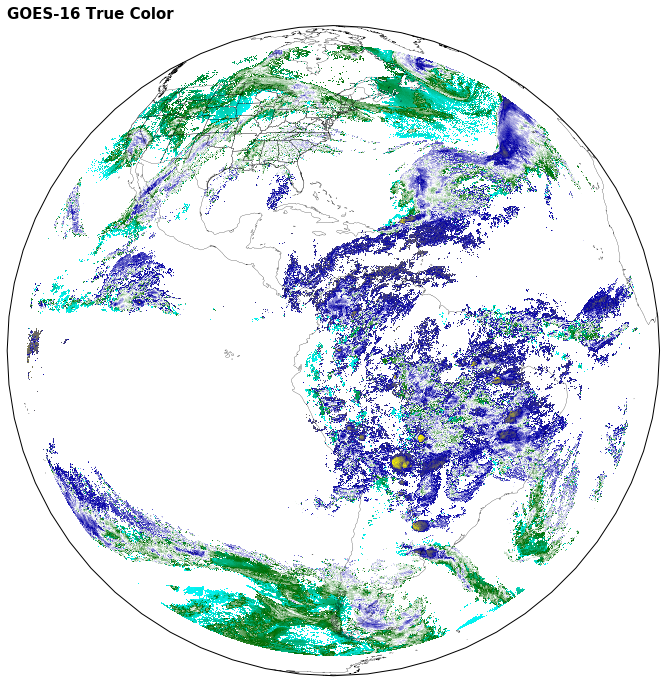

In [227]:
fig = plt.figure(figsize=(15, 12))

# Create axis with Geostationary projection
ax = fig.add_subplot(1, 1, 1, projection=geos)

# Add the RGB image to the figure. The data is in the same projection as the
# axis we just created.
ax.imshow(temp[::2,::2], origin='upper', cmap=cmap, norm=norm,
          extent=(x.min(), x.max(), y.min(), y.max()), transform=geos)

# Add Coastlines and States
ax.coastlines(resolution='50m', color='black', linewidth=0.25)
ax.add_feature(ccrs.cartopy.feature.STATES, linewidth=0.25)

plt.title('GOES-16 True Color', loc='left', fontweight='bold', fontsize=15)

plt.show()

Use Siphon to obtain data that is close to the time of the satellite file

